In [1]:
import numpy as np  
from keras.layers import Input, Dense
from keras.models import Model
from keras.models import load_model

from processing_functions_mnist import * 

import os
os.chdir('../') # Go to the parent folder
from support_functions import *
from Autoencoder_Functions import *
os.chdir('MNIST')

Using TensorFlow backend.


## Parameters

In [2]:
anomaly_digit = 2 # Set digit 2 as our anomaly
k = 50 # Define the k parameter for the precision at k

## Read Data

In [3]:
data_path = 'data/input_data/'
model_path = 'model_autoencoder.h5'
# Read image matrix (n*m), labels (vector of m), and image size
imgs_train, imgs_test, labels_train, labels_test, height, width = read_process_data(data_path, anomaly_digit)

## Implement the Anomaly Detection¶with Construction Error

Below are examples of the Reconstructed Data with Deep Autoencoder


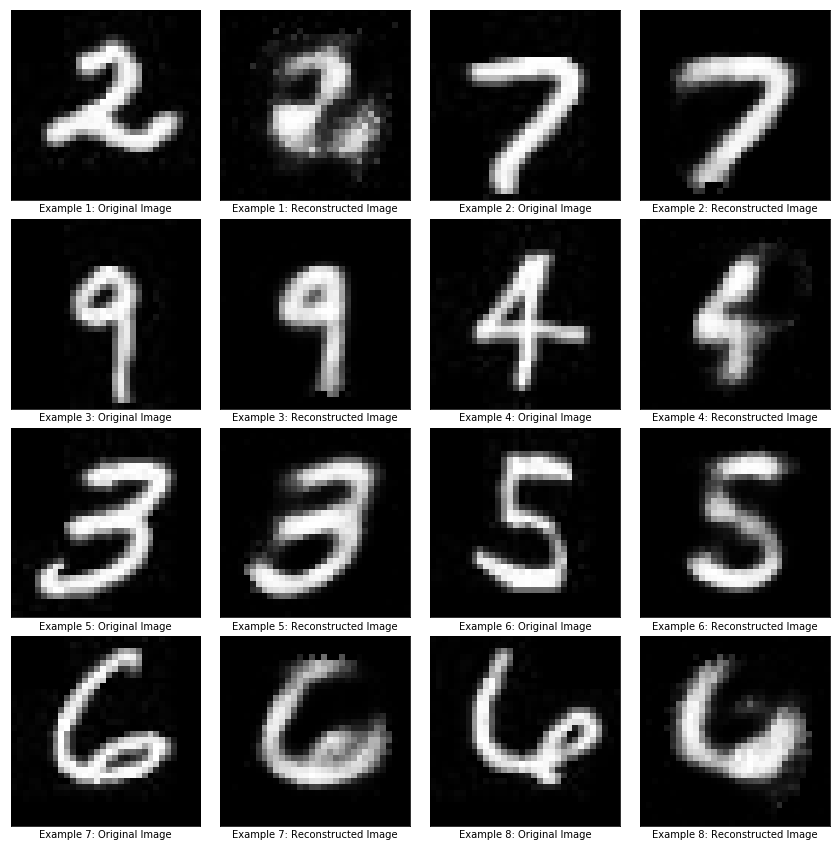

Below is a scatter plot that ranks the data points according to their Reconstruction Errors.
The higher the reconstruction error, the more likely the point will be detected as an anomaly
The Black Points are True Anomalies, while the others are True Normal points


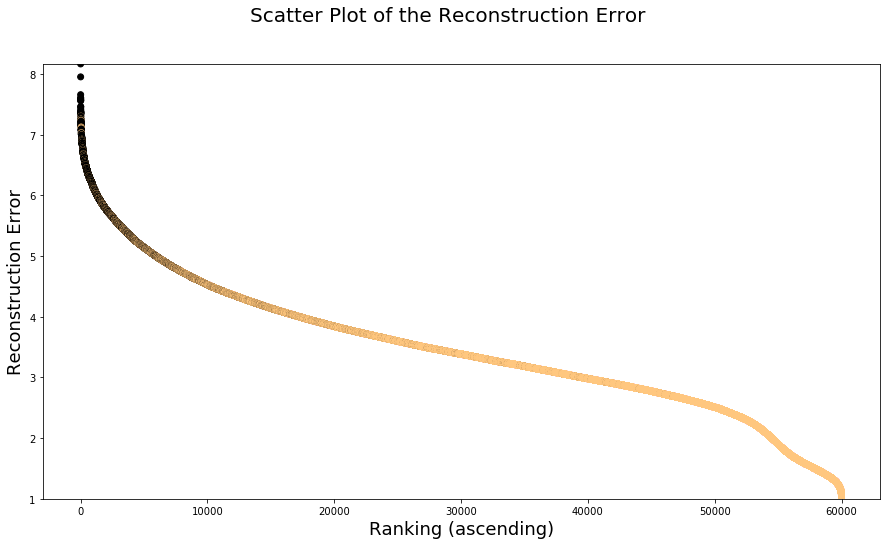


Training Results:
Precision: 54.6%
Recall: 68.7%
F-score: 60.8%
R-Precision (# R = 5958.0): 60.1%
Precision@50: 86.0%


Testing Results:
Precision: 57.3%
Recall: 61.8%
F-score: 59.5%
R-Precision (# R = 1032.0): 59.7%
Precision@50: 92.0%



In [4]:
detection_with_autoencoder_reconstruction_error(imgs_train, imgs_test,labels_train,labels_test,k,model_path,to_print = True,height=height,width=width)